In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.applications import MobileNet
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()

'/content'

In [ ]:
path = '/content/drive/MyDrive/Dataset'

In [ ]:
import shutil
import random
# Organize data into train, valid, test dirs
os.chdir(path)
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')


In [ ]:
os.listdir(path)

['train', 'valid', 'test']

In [ ]:
# Ensure that the valid and test directories have the correct number of samples
for i in range(0, 10):
    assert len(os.listdir(f'{path}/valid/{i}')) == 30
    assert len(os.listdir(f'{path}/test/{i}')) == 5
    # print(f" {i} has {len(os.listdir(f'{path}/train/{i}'))}")


In [ ]:
# Load MobileNet and get the output of the 5th-to-last layer
mobile = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
feature_layer = mobile.layers[-5].output
flattened_output = Flatten()(feature_layer)
feature_extractor = tf.keras.Model(inputs=mobile.input, outputs=flattened_output)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Set paths
train_path = f'{path}/train'
valid_path = f'{path}/valid'
test_path = f'{path}/test'

In [ ]:
# Prepare Data Generators/
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=20,         # Random rotation between 0 and 20 degrees
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    shear_range=0.2,           # Shear transformation
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flip
    fill_mode='nearest'        # Fill pixels with nearest value
                                  ).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10, shuffle=False)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
# Extract Features for Training, Validation, and Test Sets
train_features = feature_extractor.predict(train_batches, verbose=1)
train_labels = train_batches.classes

valid_features = feature_extractor.predict(valid_batches, verbose=1)
valid_labels = valid_batches.classes

test_features = feature_extractor.predict(test_batches, verbose=1)
test_labels = test_batches.classes


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [ ]:
# Scale Features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)
test_features = scaler.transform(test_features)

In [ ]:
# Train SVM
svm_classifier = SVC(kernel='linear', C = 0.5, probability=True)
svm_classifier.fit(train_features, train_labels)

SVC(C=0.5, kernel='linear', probability=True)

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30
           4       1.00      0.97      0.98        30
           5       1.00      1.00      1.00        30
           6       0.97      0.93      0.95        30
           7       0.82      0.90      0.86        30
           8       0.89      0.83      0.86        30
           9       0.97      1.00      0.98        30

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



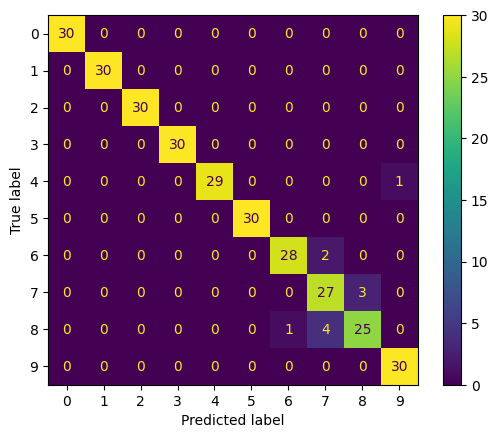

In [17]:
# Evaluate on Validation Set
val_predicted_labels = svm_classifier.predict(valid_features)
val_cm = confusion_matrix(y_true=valid_labels, y_pred=val_predicted_labels)

# Display Validation Confusion Matrix
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=cm_plot_labels).plot()
print("Validation Set Classification Report:")
print(classification_report(valid_labels, val_predicted_labels, target_names=cm_plot_labels))

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



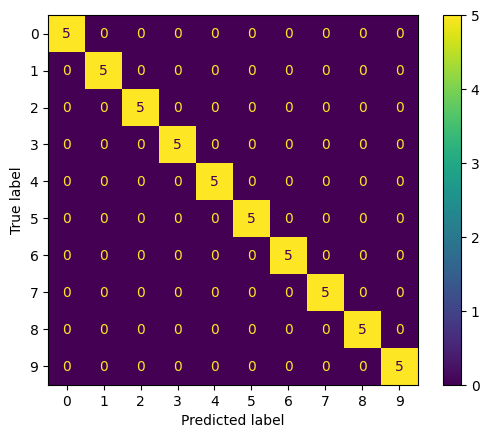

In [18]:
# Evaluate on Test Set
test_predicted_labels = svm_classifier.predict(test_features)
test_cm = confusion_matrix(y_true=test_labels, y_pred=test_predicted_labels)

# Display Test Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=cm_plot_labels).plot()
print("Test Set Classification Report:")
print(classification_report(test_labels, test_predicted_labels, target_names=cm_plot_labels))

In [19]:
# Save MobileNet feature extractor model in Keras format
feature_extractor.save("/content/drive/MyDrive/mobilenet_feature_extractor.keras")


In [20]:
import joblib
# Save the trained SVM model
joblib.dump(svm_classifier, "/content/drive/MyDrive/svm_classifier.pkl")
# Save the scaler to a file
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')

['/content/drive/MyDrive/scaler.pkl']

In [21]:
# Load the MobileNet feature extractor
from tensorflow.keras.models import load_model
feature_extractor = load_model("/content/drive/MyDrive/mobilenet_feature_extractor.keras")
# Load the SVM classifier
svm_classifier = joblib.load("/content/drive/MyDrive/svm_classifier.pkl")
scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")

In [22]:
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Load and preprocess the image from a URL
def load_and_preprocess_image_from_url(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).resize((224, 224))  # Resize to 224x224
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image
    return img_array


In [23]:
# URL of the image
img_url = 'https://c8.alamy.com/comp/W5AD08/person-hand-showing-four-fingers-W5AD08.jpg'  # Replace with your image URL# Preprocess the image
img_array = load_and_preprocess_image_from_url(img_url)

In [24]:
# Extract features from the image array
img_features = feature_extractor.predict(img_array)

# Flatten the features if needed and reshape to (1, -1) to match SVM's input format
img_features = img_features.reshape(1, -1)

# Scale the features using the same scaler used for training data
img_features = scaler.transform(img_features)

# Make predictions with the SVM classifier
predicted_class = svm_classifier.predict(img_features)

predicted_class[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


4

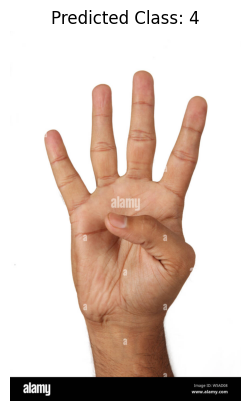

In [25]:
import matplotlib.pyplot as plt
# # Display the image and the prediction
plt.imshow(Image.open(BytesIO(requests.get(img_url).content)))  # Load and display the image
plt.title(f'Predicted Class: {predicted_class[0]}')
plt.axis('off')
plt.show()
